In [29]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import optimize
from IPython import display
import time

In [30]:
# calculates distance matrix from a list of coord tuples
def calc_d_mat(cc):
    N=len(cc)
    d=np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            d[i,j]=((cc[i][0]-cc[j][0])**2+(cc[i][1]-cc[j][1])**2+(cc[i][2]-cc[j][2])**2)
    return(d)

# error function compares distance matrix from coord list estimate to target dist mat
def error_fun(e_d,t_d):
    diff=np.tril(t_d)-np.tril(e_d)
    return(sum(sum(np.sqrt(diff**2))))

# objective function
def objfun(x,t_d):
    clist=x1d2clist(x)
    d=calc_d_mat(clist)
    e=error_fun(d,t_d)
    return(e)

def x1d2clist(x1d):
    # turn 1d array into list of tuple coords
    xc = x1d[:len(x1d)//3]
    yc = x1d[len(x1d)//3:2*len(x1d)//3]
    zc = x1d[2*len(x1d)//3:]
    clist=list(zip(xc,yc,zc))
    return(clist)

def clist2x1d(clist):
    # turn list of tuple coords into 1d array
    estxy=list(zip(*clist))
    xe=estxy[0]
    ye=estxy[1]
    ze=estxy[2]
    exy=xe+ye+ze
    x1d=np.array(exy)
    return(x1d)

def centreCoM(cc):
    # centre list of coords at its CoM 
    x,y,z=list(zip(*cc))
    xm=np.mean(x)
    ym=np.mean(y)
    zm=np.mean(z)
    x0=x-xm
    y0=y-ym
    z0=z-zm
    return(list(zip(x0,y0,z0)))


def cc_err(e,t):
    er=0
    for i in range(len(e)):
        er=er+np.sqrt((e[i][0]-t[i][0])**2+(e[i][1]-t[i][1])**2+(e[i][2]-t[i][2])**2)
    return(er)

def rot_cc(cc,a):
    rotmat=np.array(((np.cos(a[0])*np.cos(a[1]),np.cos(a[0])*np.sin(a[1])*np.sin(a[2])-np.sin(a[0])*np.cos(a[2]),np.cos(a[0])*np.sin(a[1])*np.cos(a[2])+np.sin(a[0])*np.sin(a[2])),\
                     (np.sin(a[0])*np.cos(a[1]),np.sin(a[0])*np.sin(a[1])*np.sin(a[2])+np.cos(a[0])*np.cos(a[2]),np.sin(a[0])*np.sin(a[1])*np.cos(a[2])-np.cos(a[0])*np.sin(a[2])),\
                     (-np.sin(a[1]),np.cos(a[1])*np.sin(a[2]),np.cos(a[1])*np.cos(a[2]))))
    cc_r=[np.matmul(rotmat,i).tolist() for i in cc]
    return(cc_r)

def rot_obj(a,est_cc):
    est_cc_r=rot_cc(est_cc,a)
    return(cc_err(est_cc_r,target_c3))

def match_rot(est_cc):
    res=optimize.minimize(rot_obj,[0.0,0.0,0,0],est_cc)
    return(rot_cc(est_cc,res.x))

225
225


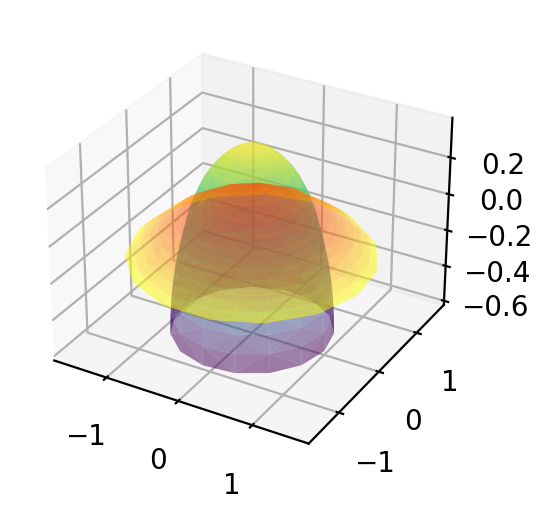

In [31]:
    
# build 3d test data, points on a hemisphere
pi=np.pi
N=15
r=1
ths=np.linspace(0,2*pi-2*pi/N,N)
phis=np.linspace(0,pi/2-(pi/2)/(N),N)
# phis=np.arange(0,pi/2,pi/2/(N/2))
target_c3=[]
for th in ths:
    for phi in phis:
        target_c3.append((r*np.cos(phi)*np.cos(th),r*np.cos(phi)*np.sin(th),r*np.sin(phi)))
target_c3=centreCoM(target_c3)

#ideal obs matrix (used in fitting)
target_d3=calc_d_mat(target_c3)

# initial estimate
r=4
ths=np.linspace(0,2*pi-2*pi/N,N)+0.3
# phis=np.arange(pi/3,pi/2,pi/2/(N/2))
phis=np.linspace(3*pi/8,pi/2-(pi/2 -3*pi/8)/(N),N)

est_c3=[]
for th in ths:
    for phi in phis:
        est_c3.append((r*np.cos(phi)*np.cos(th),r*np.cos(phi)*np.sin(th),r*np.sin(phi)))
est_c3=centreCoM(est_c3)


# target_c3=rot_cc(target_c3,[0,pi/4,0])
xt,yt,zt=list(zip(*target_c3))
xe,ye,ze=list(zip(*est_c3))

plt.figure(figsize=(6,3),dpi=200)
ax = plt.axes(projection='3d')

# ax.scatter3D(xt, yt, zt,c=zt)
# ax.scatter3D(xe, ye, ze,c=zt)

ax.plot_trisurf(xe, ye, ze,cmap='autumn_r', edgecolor='none',alpha=0.5);
ax.plot_trisurf(xt, yt, zt,cmap='viridis', edgecolor='none',alpha=0.5);
print(len(est_c3))
print(len(target_c3))


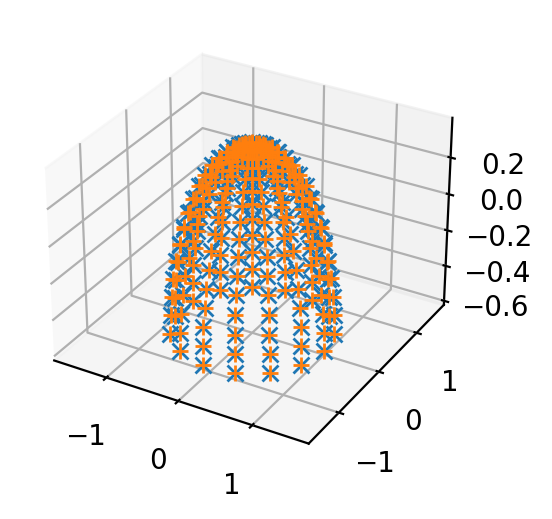

In [ ]:
# plotting
fig=plt.figure(figsize=(3,3),dpi=200)
ax = plt.axes(projection='3d')
# ax=plt.axes()
hdisplay = display.display("", display_id=True)

ax.plot3D(xt,yt,zt,'x')
h=ax.plot3D(xe,ye,ze,'+')
# ax.plot(xt,zt,'x')
# h=ax.plot(xe,ze,'+')


# h=ax.plot_trisurf(xe, ye, ze,cmap='autumn_r', edgecolor='none',alpha=0.5);
# ax.plot_trisurf(xt, yt, zt,cmap='viridis', edgecolor='none',alpha=0.5);
# ax.set_xlim((-1.5, 1.5))
# ax.set_ylim((-1.5, 1.5))

# fitting
est_obj_x1d=clist2x1d(est_c3)
status=1
n=0
while status>=1:
    n=n+1
#     print(n)
    result=optimize.minimize(objfun,est_obj_x1d,target_d3,method='POWELL',options={'maxiter':1})
    est_obj_x1d=result.x;

    # update figure
    optclist=match_rot(centreCoM(x1d2clist(result.x)))
#     optclist=(centreCoM(x1d2clist(result.x)))
    xo,yo,zo=list(zip(*optclist))
    h[0].set_data_3d((xo,yo,zo))
#     h[0].set_data((xo,zo))
    
    hdisplay.update(fig)

    status=result.status
plt.close(fig)
print(result.message)
print(result.fun)
print(result.success)
print(result.status)

#Solver notes:
#POWELL slow but fast convergenceper iter
#TNC,COBYLA slow converge


In [1]:
fig=plt.figure(figsize=(3,3),dpi=200)
ax = plt.axes(projection='3d')
h=ax.plot3D(xt,yt,zt,'x')
h=ax.plot3D(xo,yo,zo,'+')


NameError: name 'plt' is not defined